## Corrección de Langbein - Ejemplos de su aplicación

### El objetivo de estos ejercicios es entender cuando corresponde, cuando no y cuando puede ser innecesario aplicar la corrección de Langbein en los distintos tipos de casos que se pudieran llegar a plantear.

### A partir de la serie de caudales medios diarios máximos anuales correspondientes al río Carrenleufú en la estación La Elena se pide:
### 1. Importar los datos y gaficar la serie de caudales máximos anuales.
### 2. Ajustar la muestra a una función de distribución de probabilidad EV1 (Gumbel). Estimar los parámetros de la misma a través del método de los momentos ordinarios (MO).
### 3. Obtener los caudales asociados a distintos períodos de retorno.
### 4. Obtener los períodos de retorno asociados a distintos caudales.
### 5. Calcular el período de retorno y el caudal de diseño de una obra cuya vida util será de 50 años y el riesgo asumido del 10%.
### 6. Calcular el riesgo que se asume al diseñar otra obra para un caudal de 100 m3/s y vida util de 50 años.

In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, dirname

In [2]:
# Defino función para hacer un preview de los primeras y últimas n filas de los dataframes (dfs).
def df_preview(df, n):
    return pd.concat([df.head(n), df.tail(n)]) 

### 1. Importar los datos y gaficar la serie de caudales máximos anuales.

In [3]:
# Se importa la serie de caudales máximos anuales.
df_qma = pd.read_csv('https://raw.githubusercontent.com/JMM385/Langbein/main/data/carrenleufu_la_elena_qma.csv', 
                     encoding='latin1')
# Se eliminan valores NANs
df_qma = df_qma.dropna()
# Se convierte la columna 'Fecha y Hora' al tipo DateTime
df_qma['Fecha y Hora'] = pd.to_datetime(df_qma['Fecha y Hora'])
df_preview(df_qma, 3)

,Fecha y Hora,Caudal Medio Diario Máximo [m3/s]
0,1954-01-04,77.90
1,1955-01-04,66.80
2,1956-01-04,44.10
61,2017-01-04,99.57
62,2018-01-04,278.74
63,2019-01-04,61.72


In [4]:
# Se modifica el nombre de las columnas por uno más corto.
df_qma = df_qma.rename(columns={'Fecha y Hora' : 'Year',
                                'Caudal Medio Diario Máximo [m3/s]' : 'QMA[m3/s]' 
                               })
# Se define a la columna ['Year'] como index del dataframe y el formato de la fecha.
df_qma = df_qma.set_index('Year').to_period('Y')

In [5]:
df_preview(df_qma, 3)

,QMA[m3/s]
Year,
1954,77.90
1955,66.80
1956,44.10
2017,99.57
2018,278.74
2019,61.72


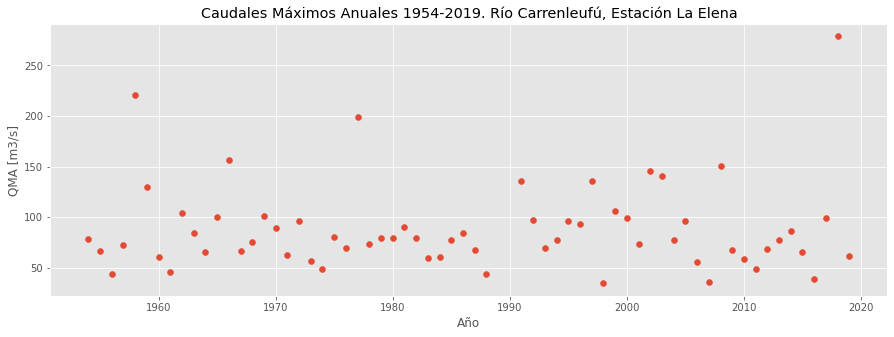

In [6]:
# Se define el estilo a utilizar en los gráficos.
mpl.style.use('ggplot') 

# Se define gráfico para visualizar los QMA vs t.
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_qma.index.to_timestamp(), df_qma.values)

ax.set_title('Caudales Máximos Anuales 1954-2019. Río Carrenleufú, Estación La Elena')
ax.set_ylabel('QMA [m3/s]')
ax.set_xlabel('Año')

plt.show();

### 2. Ajustar la muestra a una función de distribución de probabilidad EV1. Estimar los parámetros de la misma a través del método de los momentos ordinarios.

#### El desvio y la media de la muestra se calculan con la libreria Numpy.
#### Los parámetros u y $\alpha $ por el método de los momentos ordinarios se definen como:
$$
\alpha = \frac{\sqrt{6} S_{Q}}{\pi} 
$$
$$
u = \tilde{Q} - 0,5772 \alpha
$$

In [7]:
S_q = np.std(df_qma['QMA[m3/s]']) # Desvío estandar de la muestra [m3/s]
Q = np.mean(df_qma['QMA[m3/s]']) # Media de la muestra [m3/s]
# Estimación de los parámtros u y alpha por momentos ordinarios
alpha = np.sqrt(6) * S_q / np.pi # Parámetro de escala [m3/s]
u = Q - 0.5772 * alpha # Moda, parámetro de ubicación [m3/s]
print('El desvío estandar es: ', round(S_q, 3), 'm3/s','\n'
      'La media es: ', round(Q, 3),'m3/s','\n'
      'El parámetro alpha es: ', round(alpha, 3), 'm3/s','\n'
      'El parámetro u es: ', round(u, 3), 'm3/s','\n'
     )

El desvío estandar es:  42.834 m3/s 
La media es:  88.106 m3/s 
El parámetro alpha es:  33.397 m3/s 
El parámetro u es:  68.829 m3/s 



#### Se esta en condiciones de obtener las funciones de distribución acumulada y de densidad de la distribución de Gumbel definidas respectivamente según:
$$
F(Q) = e^{-e^{-(\frac{Q-u}{\alpha})}}
$$
$$
f(Q) = \frac{1}{\alpha}  e^{-(\frac{Q-u}{\alpha})}  e^{-e^{-(\frac{Q-u}{\alpha})}}
$$

In [8]:
# Se define df para obtener la función de distribución acumulada y de densidad 
# (dependientes del caudal).
df_gumbel = pd.DataFrame()
df_gumbel['Q'] = np.arange(0, 2005, 5)

df_gumbel['F'] = np.exp(-np.exp(-((df_gumbel['Q'] - u) / alpha)))
df_gumbel['f'] = (1/alpha) * np.exp(-((df_gumbel['Q'] - u) / alpha)) * np.exp(-np.exp(-((df_gumbel['Q'] - u) / alpha)))

df_gumbel.tail()

,Q,F,f
396,1980,1.0,4.205293e-27
397,1985,1.0,3.620573e-27
398,1990,1.0,3.117154e-27
399,1995,1.0,2.683733e-27
400,2000,1.0,2.310576e-27


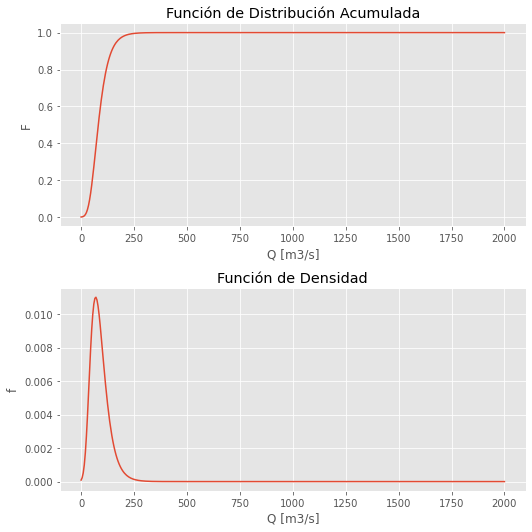

In [9]:
# Se define gráfico para visualizar las funciones de probabilidad acumulada y de densidad.
fig, ax = plt.subplots(2, 1, figsize=(7.5, 7.5))

ax[0].plot(df_gumbel['Q'], df_gumbel['F'])
ax[1].plot(df_gumbel['Q'], df_gumbel['f'])

ax[0].set_title('Función de Distribución Acumulada')
ax[0].set_ylabel('F')
ax[0].set_xlabel('Q [m3/s]')

ax[1].set_title('Función de Densidad')
ax[1].set_ylabel('f')
ax[1].set_xlabel('Q [m3/s]')

fig.tight_layout()
plt.show();

### 3. Obtener los caudales asociados a distintos períodos de retorno.

#### Antes de obtener los cuantiles debe aplicarse la corrección al período de retorno según la expresión que propone Langbein:
$$
T_{am} = \frac{1}{1-e^\frac{-1}{T}}
$$
#### Luego se está en condiciones de obtener cuantiles asociados al período de retorno original pero utilizando $T_{am}$ en lugar de T en la expresión del cuantil tal como se muestra a continuación:
$$
Q_{T} = u + \alpha(-ln(-ln(1 - \frac{1}{T_{am}})))
$$

#### Se calculan los períodos de retorno corregidos para distintas recurrencias y se observan los valores obtenidos y su incidencia.

In [10]:
# Se define df con distintos períodos de retorno y su valor asociado según 
# la corrección que propone Langbein.
df_T = pd.DataFrame()
df_T['T'] = np.arange(2, 1001, 1)
df_T['T_am'] = 1 / (1 - np.exp (-1/df_T['T']))

df_preview(df_T, 5)

,T,T_am
0,2,2.541494
1,3,3.527726
2,4,4.520812
3,5,5.516656
4,6,6.513882
994,996,996.500084
995,997,997.500084
996,998,998.500084
997,999,999.500083
998,1000,1000.500083


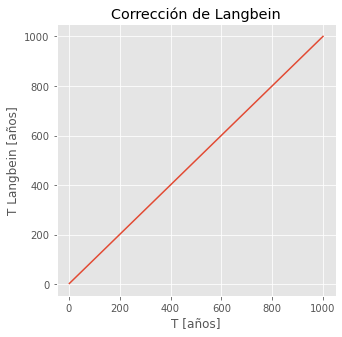

In [11]:
# Se define figura para visualizar T vs Tam.
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(df_T['T'], df_T['T_am'])

ax.set_title('Corrección de Langbein')
ax.set_ylabel('T Langbein [años]')
ax.set_xlabel('T [años]')

plt.show();

#### El gráfico no es muy orientativo ya que aparenta ser una recta a 45°. De todas formas tener en cuenta que siempre existe una diferencia aunque sea mínima entre el período de retorno original y el corregido por Langbein.

#### A continuación se analiza la diferencia entre aplicar o no la corrección:

In [12]:
# Se define df para ver la diferencia entre aplicar o no la corrección a distintos períodos
# de retorno. 
df_T['Q_Tam'] = u + alpha * (-np.log(-np.log(1-(1/df_T['T_am']))))
df_T['Q_T'] = u + alpha * (-np.log(-np.log(1-(1/df_T['T']))))

df_T['dif_%'] = 100 * (df_T['Q_Tam'] - df_T['Q_T']) / df_T['Q_Tam'] # Diferencia % entre Q_Tam y Q_T

df_preview(df_T, 5)

,T,T_am,Q_Tam,Q_T,dif_%
0,2,2.541494,91.978440,81.069672,11.860135
1,3,3.527726,105.519960,98.977663,6.200057
2,4,4.520812,115.127822,110.438979,4.072728
3,5,5.516656,122.580258,118.923301,2.983316
4,6,6.513882,128.669342,125.671044,2.330235
994,996,996.500084,299.396948,299.380175,0.005602
995,997,997.500084,299.430462,299.413706,0.005596
996,998,998.500084,299.463944,299.447204,0.005590
997,999,999.500083,299.497391,299.480669,0.005584
998,1000,1000.500083,299.530805,299.514100,0.005577


#### Como se puede ver,  la diferencia entre aplicar la corrección o no es mucho más notoria para períodos de retorno bajos. Visualmente se ve de la siguiente manera:

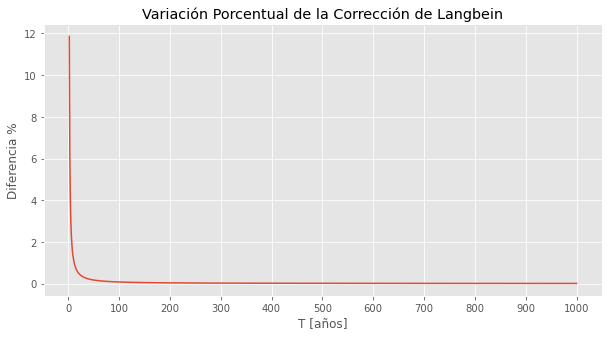

In [13]:
# Se define gráfico para visualizar la variación porcentual entre aplicar o no corrección
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_T['T'], df_T['dif_%'])

ax.set_title('Variación Porcentual de la Corrección de Langbein')
ax.set_ylabel('Diferencia %')
ax.set_xlabel('T [años]')

plt.xticks(np.arange(0, 1100, 100))

plt.show();

#### Finalmente, se grafica la relación Caudal vs Período de Retorno habiendo aplicado la corrección tal como se debe:

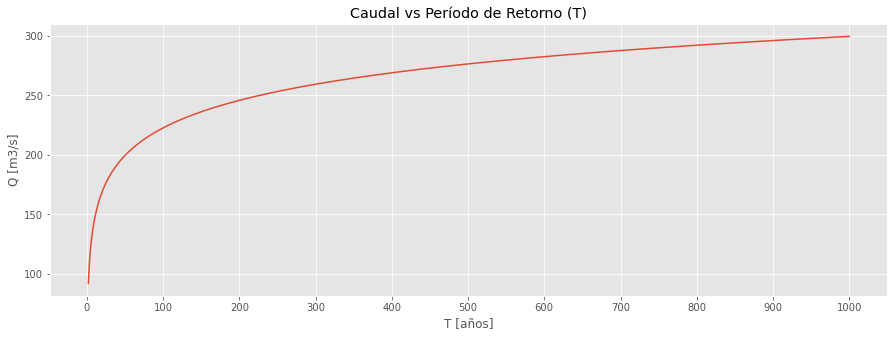

In [14]:
# Se define gráfico para visualizar el caudal vs el período de retorno.
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_T['T'], df_T['Q_Tam'])

ax.set_title('Caudal vs Período de Retorno (T)')
ax.set_ylabel('Q [m3/s]')
ax.set_xlabel('T [años]')

plt.xticks(np.arange(0, 1100, 100))

plt.show();

### 4. Obtener los períodos de retorno asociados a distintos caudales.

#### Lo correcto es despejar el período de retorno de Langbein de la expresión del cuantil y luego aplicar la corrección pero en el sentido inverso y así obtener el período de retorno original. La expresiónes despejadas que se tienen que resolver entonces son las siguientes:
$$
T_{am} = \frac{1}{1 - e^{-e^{-(\frac{Q_{T}-u}{\alpha})}}}
$$
\
\
$$
T = \frac{-1}{ln(1 - \frac{1}{T_{am}})}
$$

In [15]:
# Se define df para almacenar el perído de retorno asociado a diferentes cuantiles.
df_Q = pd.DataFrame()

df_Q['Q'] = np.arange(25, 525, 25)

df_Q['T_am'] = 1 / (1 - np.exp(-np.exp(-(df_Q['Q'] - u) / alpha)))

# Se aplica la correción de Langbein pero en el sentido inverso.
df_Q['T'] = -1 / np.log(1 - (1 / df_Q['T_am']))

df_Q['T_am'] = df_Q['T_am'].apply(lambda x: '%.1f' % x)
df_Q['T'] = df_Q['T'].apply(lambda x: '%.1f' % x)

df_preview(df_Q, 3)

,Q,T_am,T
0,25,1.0,0.3
1,50,1.2,0.6
2,75,1.8,1.2
17,450,90505.3,90504.8
18,475,191323.3,191322.8
19,500,404447.7,404447.2


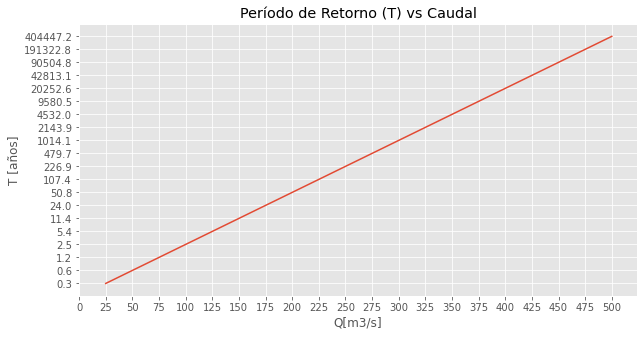

In [16]:
# Se define gráfico para visualizar el periodo de retorno vs caudal.
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_Q['Q'], df_Q['T'])

ax.set_title('Período de Retorno (T) vs Caudal')
ax.set_ylabel('T [años]')
ax.set_xlabel('Q[m3/s]')

plt.xticks(np.arange(0, 525, 25))

plt.show();

#### Cuidado que en el gráfico anterior los valores indicados se encuentran equidistanciados para poder representarlos graficamente pero en realidad no es así.

### 5. Calcular el período de retorno y el caudal de diseño de una obra cuya vida util será de 50 años y el riesgo asumido del 10%.

#### En este caso aparece una nueva expresión que es la del riesgo y se define de la siguiente manera:
$$
R = 1 - (1 - \frac{1}{T})^{N}
$$
#### **Cuidado**: en este caso T representa el período de retorno original y no el corregido por Langbein.
#### En este caso se tienen los datos como para despejar el período de retorno original de la fórmula de riesgo, luego corregirlo por Langbein y así poder finalmente determinar el caudal de diseño.

In [17]:
R = 0.10 
N = 50 # años
T = 1 / (1 - (1 - R) ** (1/N))
T_am = 1 / (1 - np.exp(-1/T))
Q = u + alpha * (-np.log(-np.log(1 - (1/T_am))))

print('El período de retorno es: ', round(T, 3), 'años','\n'
      'El caudal de diseño es: ', round(Q, 3), 'm3/s'
     )

El período de retorno es:  475.061 años 
El caudal de diseño es:  274.673 m3/s


### 6. Calcular el riesgo que se asume al diseñar dicha obra para un caudal de 100 m3/s y vida util de 50 años.

#### El ejercicio es similar al anterior pero al revés. A partir de la expresión del cuantil se despeja el período de retorno corregido por Langbein, luego se calcula el período de retorno original y con este finalmente el riesgo asumido. 

In [18]:
Q = 200 # m3/s
N = 50 # años
T_am = 1 / (1 - np.exp(-np.exp(-(Q - u) / alpha)))

# Se aplica la correción de Langbein pero en el sentido inverso.
T = -1 / np.log(1 - (1 / T_am))
R = 1 - (1 - (1/T)) ** N
print('El período de retorno corregido es: ', round(T_am, 3), '\n'
      'El período de retorno real es: ', round(T, 3),'\n'
      'El riego asumido es: ', round(R, 3)
     )

El período de retorno corregido es:  51.285 
El período de retorno real es:  50.783 
El riego asumido es:  0.63


## Conclusiones
#### 1 - La corrección de Langbein solo debe aplicarse si el modelo utilizado es el de máximos anuales. La corrección busca corregir falencias del modelo. Al considerar un único valor por año, puede que eventos (independientes) que no fueron los máximos de su año de ocurrencia queden fuera de la muestra. Esto trae aparejado que los períodos de retorno calculados resulten exagerados.
#### 2 - Un criterio es aplicarlo siempre independientemente del período de retorno que se esté analizando. De todos modos, tampoco está mal no utilizarlo cuando su incidencia deja de ser relevante. Lo importante siempre es justificar y aclarar el criterio adoptado.
#### 3 - ¿La corrección de Langbein me deja del lado de la seguridad? Sí, vean en los ejemplos que al despejar caudales, los resultados son mayores al aplicar la corrección o en el caso inverso al despejar períodos de retorno reales los resutados son menores que los corregidos.